In [202]:
import time
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn import metrics
from scipy import stats
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split

In [210]:
def calcprecall(cf):
    classes = cf.shape[0]
    TP = np.diag(cf)
    FP = np.sum(cf, axis=0) - TP
    FN = np.sum(cf, axis=1) - TP

    accuracy = np.trace(cf)/(np.sum(np.sum(cf)))*100
    precision = (np.sum(TP / (TP + FP))/classes)*100
    recall = (np.sum(TP / (TP + FN))/classes)*100
    F1score = (2*precision*recall)/(precision+recall)
    return accuracy, precision, recall, F1score

def draw_roc_curve(y_test,classes,classifier):
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    y_test = y_test.reshape(y_test.shape[0],n_classes)
    y_score = y_score.reshape(y_test.shape[0],n_classes)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    ys = [1 for i in range(classes)]
    colors = cm.rainbow(np.linspace(0, 1, len(ys)))

    for i  in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

## Filter out noisy samples and relabel mislabeled data

In [209]:
tdata = np.loadtxt("punjab_data.txt")

X = tdata[:,0:15]
Y = tdata[:,15]
m = X.shape[0]
n = X.shape[1]
skf = StratifiedKFold(n_splits=10)
classes = 9

# initializing confusion matrices to zero
CfKNN =np.zeros(classes)
CfDT =np.zeros(classes)
CfGNB =np.zeros(classes)
CfSVM =np.zeros(classes)
CfRF =np.zeros(classes)

filteredX = np.array([]).reshape(0,n)
filteredY = np.array([]).reshape(0,1)

# theses matrices would include all samples and their corresponding values in the order as selected by skf 
Xkf = np.array([]).reshape(0,n)
Ykf = np.array([]).reshape(0,1)
YNewkf = np.array([]).reshape(0,1)
pknn = np.array([]).reshape(0,1)
pdt = np.array([]).reshape(0,1)
pgnb = np.array([]).reshape(0,1)
psvm = np.array([]).reshape(0,1)
prf = np.array([]).reshape(0,1)
votes = np.array([]).reshape(0,1)

names = ['B1','B2', 'B3', 'B4', 'B5', 'B6','B7','B8','B8A','B9','B10','B11', 'B12','VH','VV'];

for train_index, test_index in skf.split(X,Y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    m_test = X_test.shape[0]
    
#   copy y_test to y_tes_new
    y_test_new  = np.copy(y_test)
    
#   training and testing with knn
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    predictKNN = knn.predict(X_test)
    cf = confusion_matrix(y_test, predictKNN)
    CfKNN = CfKNN + cf

#   training and testing with tree
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    predictDT = dt.predict(X_test)
    cf = confusion_matrix(y_test, predictDT)
    CfDT = CfDT + cf
    
#   training and testing with baysian
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictGNB = gnb.predict(X_test)
    cf = confusion_matrix(y_test, predictGNB)
    CfGNB = CfGNB + cf

#   training and testing with SVM
    svm = SVC(kernel='rbf',gamma='scale') 
    svm.fit(X_train, y_train)
    predictSVM = svm.predict(X_test)
    cf = confusion_matrix(y_test, predictSVM)
    CfSVM = CfSVM + cf
    
    
#   training and testing with RF
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    predictRF = rf.predict(X_test)
    cf = confusion_matrix(y_test, predictRF)
    CfRF = CfRF + cf
    
#   get correctly predicted labels based on major voting
    KNNVotes = 1*(predictKNN == y_test)
    DTVotes =  1*(predictDT == y_test)
    GNBVotes = 1*(predictGNB == y_test)
    SVMVotes = 1*(predictSVM == y_test)
    RFVotes = 1*(predictRF == y_test)
    totalVotes = KNNVotes + DTVotes + GNBVotes + SVMVotes + RFVotes
    
#   concatenate predictions of all algorithms column wise for each sample in test set
    predictions = np.concatenate([predictKNN.reshape(m_test,1),predictDT.reshape(m_test,1),
                                      predictGNB.reshape(m_test,1),predictSVM.reshape(m_test,1),
                                      predictRF.reshape(m_test,1)],axis = 1)
    
#   labels predicted by most of times in all algorithms for each sample in test set
    mode_labels = np.squeeze(stats.mode(predictions.T)[0])
#   how many algorithms predicted the "mode_labels" for each sample in test set
    count_labels = np.squeeze(stats.mode(predictions.T)[1]) 
    
#   conditions for when to relabel and index  
    checkForRelabel = (count_labels>=4) & (totalVotes!=count_labels)
    
#   get indices for which "checkForLabel" conditions is true    
    relabelIndices = np.asarray(np.where(checkForRelabel))
    relabelIndices = relabelIndices.reshape(relabelIndices.shape[1],1)
    
#   relabel y_test_new for the indices "relabelIndices""
    y_test_new[relabelIndices]  = mode_labels[relabelIndices]
    
#   filtered samples would include include all samples for which
#   "totalVotes>=(total Algorithms)/2" and all relabelled samples    
    filteredIndices = np.asarray(np.where((totalVotes>=3)|(checkForRelabel)))
    filteredIndices = filteredIndices.reshape(filteredIndices.shape[1],1)

#   get values from X_test and Y_test_new and "filteredIndices"  
    filteredXTest = np.take(X_test, filteredIndices, axis = 0)
    filteredXTest = filteredXTest.reshape(filteredXTest.shape[0],filteredXTest.shape[2])
    filteredYTest = np.take(y_test_new,filteredIndices)
    
#   concatenate "filtered X and Y from next test set" with "filtered X and Y from previous test sets"     
    filteredX = np.concatenate([filteredX,filteredXTest])
    filteredY = np.concatenate([filteredY,filteredYTest])

#   concatenating Xtest, Ytest, YtestNew, preidctions from all algorithms, totalVotes for each of n test sets
    Xkf = np.concatenate([Xkf,X_test])
    Ykf = np.concatenate([Ykf,y_test.reshape(m_test,1)])
    YNewkf = np.concatenate([YNewkf,y_test_new.reshape(m_test,1)])
    pknn = np.concatenate([pknn,predictKNN.reshape(m_test,1)])
    pdt = np.concatenate([pdt,predictDT.reshape(m_test,1)])
    pgnb = np.concatenate([pgnb,predictGNB.reshape(m_test,1)])
    psvm = np.concatenate([psvm,predictSVM.reshape(m_test,1)])
    prf = np.concatenate([prf,predictRF.reshape(m_test,1)])
    votes = np.concatenate([votes,totalVotes.reshape(m_test,1)])
    
#final confusion matrices of all classifiers
print(CfKNN)
print(CfDT)
print(CfGNB)
print(CfSVM)
print(CfRF)

# concatenate filteredX, filtered Y 
filteredData = np.concatenate([filteredX,filteredY],axis = 1)
print(filteredData.shape)
print("number of labels updated: {}".format(np.sum(YNewkf!=Ykf)))
print("land: {}".format(np.sum(filteredY == 0)))
print("fallow: {}".format(np.sum(filteredY == 1)))
print("water: {}".format(np.sum(filteredY == 2)))
print("fodder: {}".format(np.sum(filteredY == 3)))
print("wheat: {}".format(np.sum(filteredY == 4)))
print("gram: {}".format(np.sum(filteredY == 5)))
print("maize: {}".format(np.sum(filteredY == 6)))
print("vegetable: {}".format(np.sum(filteredY == 7)))
print("trees: {}".format(np.sum(filteredY == 8)))

# sorting all the filtered data in the order of labels from 0 to classes-1
# and save it to csv file
filteredData = filteredData[filteredData[:,15].argsort()]
np.savetxt("filtered.csv", filteredData, delimiter=",")

# concatenate whole data concatenated for each of n test sets
# sort it in the order of "original labels" from 0 to classes-1
# save it to csv file
wholeData = np.concatenate([Xkf,Ykf,YNewkf,pknn,pdt,pgnb,psvm,prf,votes],axis = 1)
wholeData = wholeData[wholeData[:,15].argsort()]
np.savetxt("data.csv", wholeData, delimiter=",",header="B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12,VV,VH,Y,Y_new,KNN,DT,GNB,SVM,RF,Votes")

[[49.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 50.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 28.  8.  1.  4.  4.  5.]
 [ 0.  0.  0.  4. 26.  4.  6.  6.  4.]
 [ 0.  0.  0.  2.  0. 46.  0.  0.  2.]
 [ 0.  0.  0.  4.  8.  0. 31.  3.  4.]
 [ 0.  0.  0. 11.  6.  4.  9. 14.  6.]
 [ 0.  0.  0. 12. 12.  1.  7. 10.  8.]]
[[50.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. 49.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 21.  7.  2.  4.  2. 14.]
 [ 0.  0.  0.  8. 29.  1.  2.  4.  6.]
 [ 0.  0.  0.  0.  2. 44.  0.  2.  2.]
 [ 0.  0.  0.  3.  1.  4. 28.  6.  8.]
 [ 0.  0.  0.  3.  6.  3.  8. 19. 11.]
 [ 0.  0.  0. 11.  7.  2.  8. 10. 12.]]
[[50.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 50.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 27.  5.  3.  6.  1.  8.]
 [ 0.  0.  0.  1. 23.  5. 10.  4.  7.]
 [ 0.  0.  0.  1.  1. 45.  2.  0.  1.]
 [ 0.  0.  0.  0.  4.  0. 35.  6.  5.]
 [ 0.  0.  0.  8. 11.  

In [166]:
[acc1, pre1, rec1, f1] = calcprecall(CfKNN)
[acc2, pre2, rec2, f2] = calcprecall(CfDT)
[acc3, pre3, rec3, f3] = calcprecall(CfGNB)
[acc4, pre4, rec4, f4] = calcprecall(CfSVM)
[acc5, pre5, rec5, f5] = calcprecall(CfRF)
print("KNN: \n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc1,pre1,rec1,f1))
print("DT:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc2,pre2,rec2,f2))
print("GNB:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc3,pre3,rec3,f3))
print("SVM:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc4,pre4,rec4,f4))
print("RF: \naccuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc5,pre5,rec5,f5))

KNN: 
 accuracy = 67.11111111111111, precision = 65.46967279482195, recall = 67.11111111111111, f1-score= 66.28023090372996
DT:
 accuracy = 66.88888888888889, precision = 66.60560013608794, recall = 66.88888888888889, f1-score= 66.74694392885367
GNB:
 accuracy = 66.44444444444444, precision = 65.84840919239896, recall = 66.44444444444444, f1-score= 66.14508412298535
SVM:
 accuracy = 61.55555555555555, precision = 56.54389635955501, recall = 61.55555555555554, f1-score= 58.943388766782746
RF: 
accuracy = 74.44444444444444, precision = 73.31770802710582, recall = 74.44444444444446, f1-score= 73.8767803625325


## Perform startified KFold Validation on filtered data

In [167]:
m = filteredData.shape[0]
subsets = 10
classes = 9
a = m

# discarding classes for which total number of samples < subsets
for i in range(1,classes):
    c = np.sum(filteredY == i)
    if(c < subsets):
        a = a - c
        classes = classes - 1
        print("{} th class rejected due to lower number of samples".format(i))


X = filteredData[0:a,0:15]
Y = filteredData[0:a,15]
skf = StratifiedKFold(n_splits=subsets)
Y = Y.reshape(X.shape[0],)
CfKNN =np.zeros(classes)
CfDT =np.zeros(classes)
CfGNB =np.zeros(classes)
CfSVM =np.zeros(classes)
CfRF =np.zeros(classes)

names = ['B1','B2', 'B3', 'B4', 'B5', 'B6','B7','B8','B8A','B9','B10','B11', 'B12','VH','VV'];

for train_index, test_index in skf.split(X,Y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

     #training and testing with knn
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    predictKNN = knn.predict(X_test)
    cf = confusion_matrix(y_test, predictKNN)
    CfKNN = CfKNN + cf

    # training and testing with tree
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    predictDT = dt.predict(X_test)
    cf = confusion_matrix(y_test, predictDT)
    CfDT = CfDT + cf
    
    # training and testing with baysian
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    predictGNB = gnb.predict(X_test)
    cf = confusion_matrix(y_test, predictGNB)
    CfGNB = CfGNB + cf

    # training and testing with SVM
    svm = SVC(kernel='rbf',gamma='scale') 
    svm.fit(X_train, y_train)
    predictSVM = svm.predict(X_test)
    cf = confusion_matrix(y_test, predictSVM)
    CfSVM = CfSVM + cf
    
    
    #training and testing with RF
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    predictRF = rf.predict(X_test)
    cf = confusion_matrix(y_test, predictRF)
    CfRF = CfRF + cf
    
#confusion matrices of all classifiers
print(CfKNN)
print(CfDT)
print(CfGNB)
print(CfSVM)
print(CfRF)

8 th class rejected due to lower number of samples
[[49.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 33.  0.  1.  5.  0.]
 [ 0.  0.  0.  0. 33.  1.  5.  2.]
 [ 0.  0.  0.  0.  0. 52.  0.  0.]
 [ 0.  0.  0.  2.  4.  0. 41.  0.]
 [ 0.  0.  0.  0.  4.  1.  1.  5.]]
[[46.  2.  1.  0.  0.  0.  0.  0.]
 [ 1. 49.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 35.  0.  1.  2.  1.]
 [ 0.  0.  0.  1. 31.  1.  4.  4.]
 [ 0.  0.  0.  2.  1. 49.  0.  0.]
 [ 0.  0.  0.  2.  4.  0. 37.  4.]
 [ 0.  0.  0.  1.  3.  1.  0.  6.]]
[[49.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 37.  1.  1.  0.  0.]
 [ 0.  0.  0.  0. 34.  1.  1.  5.]
 [ 0.  0.  0.  0.  0. 49.  0.  3.]
 [ 0.  0.  0.  0.  1.  0. 44.  2.]
 [ 0.  0.  0.  1.  1.  0.  0.  9.]]
[[49.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 50.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 50.  0.  0.  0.  0.  0.]
 

In [169]:
[acc1, pre1, rec1, f1] = calcprecall(CfKNN)
[acc2, pre2, rec2, f2] = calcprecall(CfDT)
[acc3, pre3, rec3, f3] = calcprecall(CfGNB)
[acc4, pre4, rec4, f4] = calcprecall(CfSVM)
[acc5, pre5, rec5, f5] = calcprecall(CfRF)
print("KNN: \n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc1,pre1,rec1,f1))
print("DT:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc2,pre2,rec2,f2))
print("GNB:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc3,pre3,rec3,f3))
print("SVM:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc4,pre4,rec4,f4))
print("RF: \naccuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc5,pre5,rec5,f5))

KNN: 
 accuracy = 92.33038348082596, precision = 89.94921237299287, recall = 87.2239721876463, f1-score= 88.56563274830506
DT:
 accuracy = 89.38053097345133, precision = 84.64003768609348, recall = 85.59131561163773, f1-score= 85.11301870814523
GNB:
 accuracy = 94.98525073746312, precision = 91.31061789343524, recall = 93.4330745582043, f1-score= 92.35965413895055
SVM:
 accuracy = 89.67551622418878, precision = nan, recall = 80.2524516652695, f1-score= nan
RF: 
accuracy = 96.7551622418879, precision = 95.45445746665258, recall = 92.60567533141482, f1-score= 94.00848936531236


C:\Users\EE\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## SPLIT filtered data and calculate precision, accuracy, recall and f1-score for different Algorithms (KNN, Cart, Baysian, SVM, Random Forests)

In [196]:
tdata = np.loadtxt("punjab_data.txt")
# comment next two lines if you want to discard classes with very low number of samples
X = filteredData[:,0:15]
Y = filteredData[:,15]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

  #training and testing with knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
predictKNN = knn.predict(X_test)
CfKNN = confusion_matrix(y_test, predictKNN)

    # training and testing with tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predictDT = dt.predict(X_test)
CfDT = confusion_matrix(y_test, predictDT)

    
    # training and testing with baysian
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictGNB = gnb.predict(X_test)
CfGNB = confusion_matrix(y_test, predictGNB)


    # training and testing with SVM
svm = SVC(kernel='rbf',gamma='scale') 
svm.fit(X_train, y_train)
predictSVM = svm.predict(X_test)
CfSVM = confusion_matrix(y_test, predictSVM)
        
    #training and testing with RF
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
predictRF = rf.predict(X_test)
CfRF = confusion_matrix(y_test, predictRF)

#confusion matrices of all classifiers
print(CfKNN)
print(CfDT)
print(CfGNB)
print(CfSVM)
print(CfRF)
[acc1, pre1, rec1, f1] = calcprecall(CfKNN)
[acc2, pre2, rec2, f2] = calcprecall(CfDT)
[acc3, pre3, rec3, f3] = calcprecall(CfGNB)
[acc4, pre4, rec4, f4] = calcprecall(CfSVM)
[acc5, pre5, rec5, f5] = calcprecall(CfRF)
print("KNN: \n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc1,pre1,rec1,f1))
print("DT:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc2,pre2,rec2,f2))
print("GNB:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc3,pre3,rec3,f3))
print("SVM:\n accuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc4,pre4,rec4,f4))
print("RF: \naccuracy = {}, precision = {}, recall = {}, f1-score= {}".format(acc5,pre5,rec5,f5))

[[18  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  1  0  0]
 [ 0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0]
 [ 0  0  0  3  0  0 12  0  0]
 [ 0  0  0  0  3  0  0  1  0]
 [ 0  0  0  0  3  0  2  0  0]]
[[18  0  0  0  0  0  0  0  0]
 [ 1 17  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  3  0  0]
 [ 0  0  0  0 10  1  0  1  0]
 [ 0  0  0  0  1 10  0  0  0]
 [ 0  0  0  2  1  0 12  0  0]
 [ 0  0  0  0  1  0  1  2  0]
 [ 0  0  0  0  4  0  1  0  0]]
[[18  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  1]
 [ 0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  1  9  0  1  0]
 [ 0  0  0  0  1  0 12  1  1]
 [ 0  0  0  0  1  0  0  3  0]
 [ 0  0  0  0  1  0  3  0  1]]
[[18  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  1  0  0]
 [ 0  0  0  0 11  1  0  0  0]
 [ 0  0  0  0  0 11  0  0  0]
 [ 0  0

C:\Users\EE\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## Draw ROC Curves for KNN, Cart, Baysian, SVM and Random forests (using filtered data)

9
[0. 1. 2. 3. 4. 5. 6. 7. 8.]


<IPython.core.display.Javascript object>


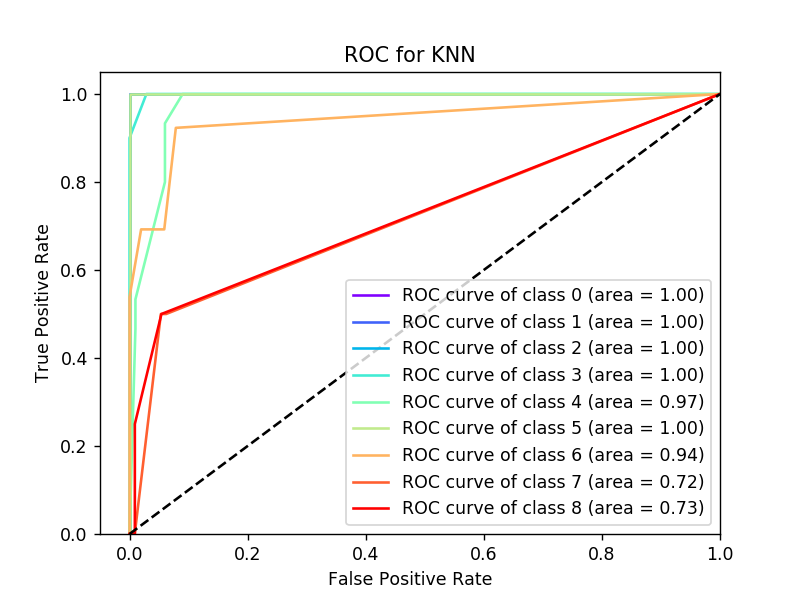

<IPython.core.display.Javascript object>


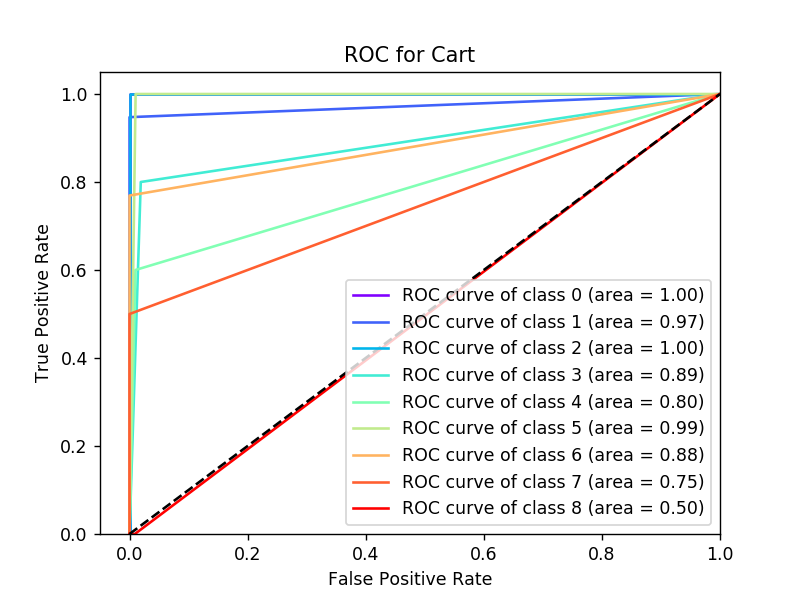

<IPython.core.display.Javascript object>


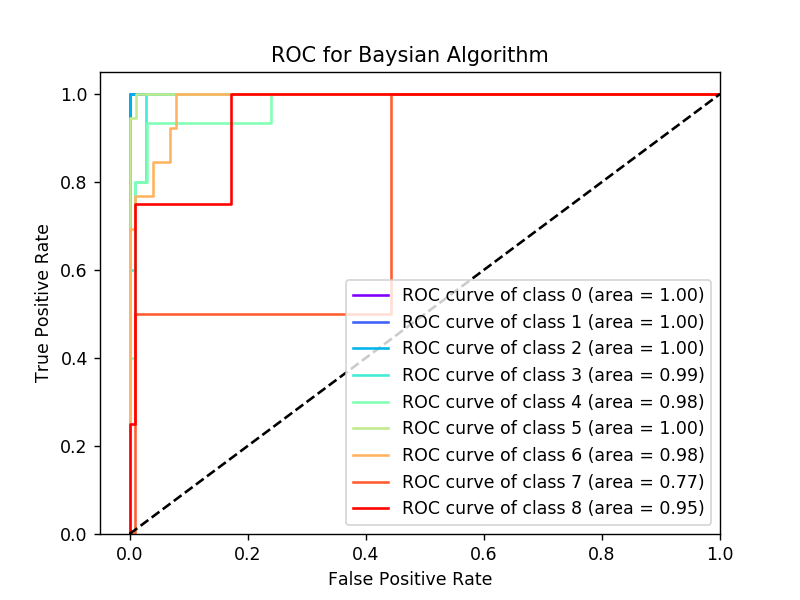

<IPython.core.display.Javascript object>


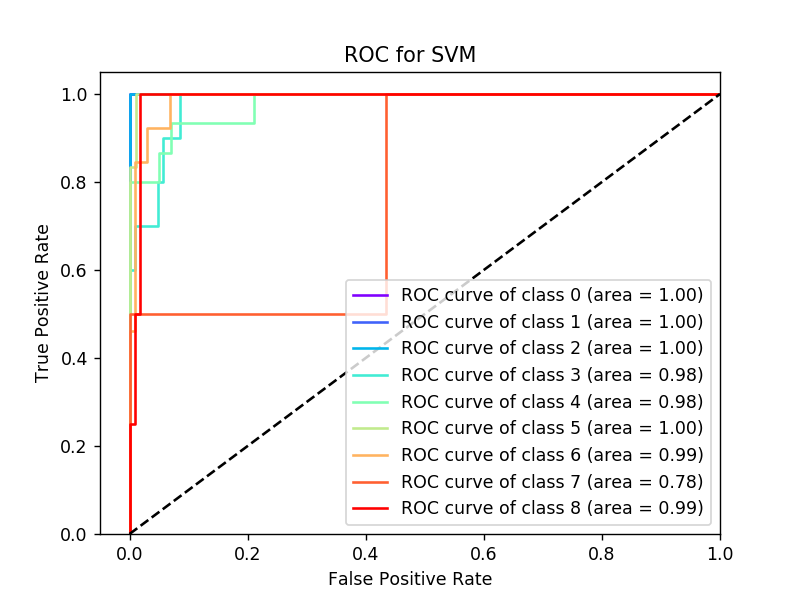

<IPython.core.display.Javascript object>


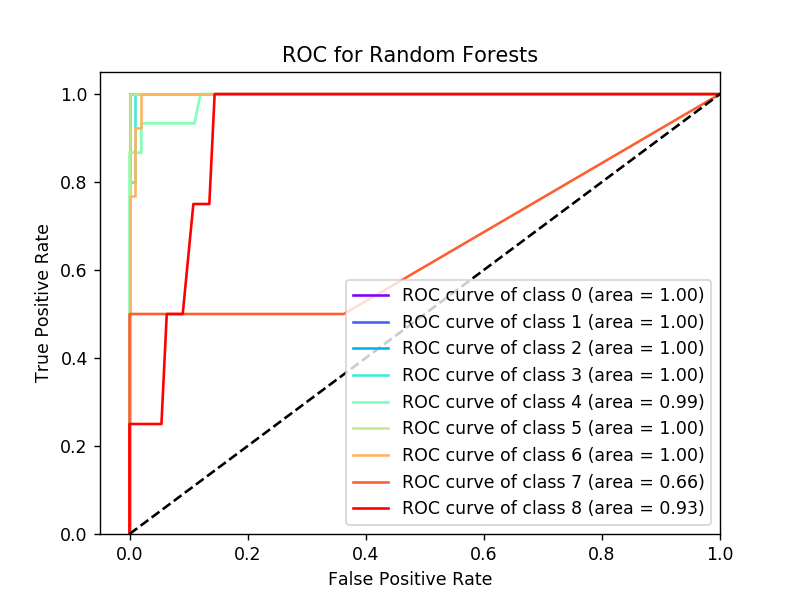

Text(0.5, 1.0, 'ROC for Random Forests')

In [206]:
X = filteredData[:,0:15]
Y = filteredData[:,15]

# getting total number of classes in Y
n_classes = int(max(Y)+1)
print(n_classes)

# Binarize the output Y
c = np.linspace(start = 0, stop = n_classes-1, num=n_classes)
y = label_binarize(Y, classes=c)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=0)

plt.figure(0)
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
draw_roc_curve(y_test,n_classes,knn)
plt.title('ROC for KNN')

plt.figure(1)
knn = OneVsRestClassifier(DecisionTreeClassifier())
draw_roc_curve(y_test,n_classes,knn)
plt.title('ROC for Cart')

plt.figure(2)
gnb = OneVsRestClassifier(GaussianNB())
draw_roc_curve(y_test,n_classes,gnb)
plt.title('ROC for Baysian Algorithm')

plt.figure(3)
knn = OneVsRestClassifier(SVC(kernel='rbf',gamma='scale',probability=True))
draw_roc_curve(y_test,n_classes,knn)
plt.title('ROC for SVM')

plt.figure(4)
rf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
draw_roc_curve(y_test,n_classes,rf)
plt.title('ROC for Random Forests')

